Notebook where to plot the curves and display the performance of all models in 
a chosen folder. It is also where to conduct the performance analysis about the
models database.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpi
import json

from scipy.stats import pearsonr, ttest_1samp
from sklearn.linear_model import LinearRegression

from contrastive.utils.config import get_config_diff
from contrastive.utils.models_database import import_bdd

In [2]:
bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models.csv", index_col=0)
bdd[bdd.exclude == 'bad_learning'].groupby(['num_representation_features','backbone_name', 'foldlabel']).count()

model_path  auc  auc_std  \
num_representation_features backbone_name foldlabel                             
4                           convnet       False               7    7        7   
                                          True                2    2        2   
                            densenet      False               6    6        6   
                                          True                5    5        5   

                                                     accuracy  accuracy_std  \
num_representation_features backbone_name foldlabel                           
4                           convnet       False             7             7   
                                          True              2             2   
                            densenet      False             6             6   
                                          True              5             5   

                                                     batch_size  drop_rate  \
num_representation_features backbone_name foldlabel                          
4                           convnet       False               7          7   
                                          True                2          2   
                            densenet      False               6          6   
                                          True                5          5   

                                                     early_stopping_patience  \
num_representation_features backbone_name foldlabel                            
4                           convnet       False                            7   
                                          True                             2   
                            densenet      False                            6   
                                          True                             5   

                                                     input_size  lr  ...  \
num_representation_features backbone_name foldlabel                  ...   
4                           convnet       False               7   7  ...   
                                          True                2   2  ...   
                            densenet      False               6   6  ...   
                                          True                5   5  ...   

                                                     max_epochs  num_outputs  \
num_representation_features backbone_name foldlabel                            
4                           convnet       False               7            7   
                                          True                2            2   
                            densenet      False               6            6   
                                          True                5            5   

                                                     temperature  \
num_representation_features backbone_name foldlabel                
4                           convnet       False                7   
                                          True                 2   
                            densenet      False                6   
                                          True                 5   

                                                     temperature_initial  \
num_representation_features backbone_name foldlabel                        
4                           convnet       False                        7   
                                          True                         2   
                            densenet      False                        6   
                                          True                         5   

                                                     train_loss  val_loss  \
num_representation_features backbone_name foldlabel                         
4                           convnet       False               7         7   
                                          True                2         2   
                            d

## Resume the results

In [3]:
def exclude_conditions(diff_config, excluded_conditions):
    excluded_subdirs = []
    for cond in excluded_conditions:
        filtered_diff_config = diff_config.query(cond)
        excluded_subdirs.extend(filtered_diff_config['Unnamed: 0'].values)
    return excluded_subdirs

dir_path = "/home/jc225751/Runs/43_supervised_contrastive_ACCpatterns/Output/supervised/densenet"
diff_config = pd.read_csv(dir_path+'/config_diff.csv')
diff_config

#exclude_conditions(diff_config, excluded_conditions=["lr != 0.0004"])

,Unnamed: 0,drop_rate,early_stopping_patience,max_epochs,temperature,temperature_initial,train_val_csv_file,backbone_name
0,tau-0.1_drop-0.0,0.00,250,300,0.1,0.1,/neurospin/dico/data/deep_folding/current/data...,NaN
1,tau-0.1_drop-0.1,0.10,250,300,0.1,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
2,tau-0.5_drop-0.0,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
3,tau-0.5_drop-0.0_2,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
4,tau-0.5_drop-0.0_3,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
5,tau-0.5_drop-0.0_percentage-variable,0.00,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
6,tau-0.5_drop-0.1,0.10,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
7,tau-0.5_drop-0.15,0.15,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
8,tau-0.5_drop-0.15_percentage-variable-75,0.15,250,300,0.5,0.5,/neurospin/dico/data/deep_folding/current/data...,NaN
9,tau-0.5_drop-0.15_percentage-variable-75_2,0.15,100,301,0.5,0.5,NaN,densenet


In [4]:
def show_results(dir_path, figsize=(16,10), return_config_diff=False, excluded_conditions=[]):
    # be sure that all models are comparable
    get_config_diff(dir_path, whole_config=False)
    diff_config = pd.read_csv(dir_path+'/config_diff.csv')

    excluded_subdirs = exclude_conditions(diff_config, excluded_conditions)
    if excluded_conditions != []:
        print("Excluded subdirs :", excluded_subdirs)
        print("Excluded because of ", excluded_conditions)

    print(diff_config[~diff_config['Unnamed: 0'].isin(excluded_subdirs)])

    paths = []
    accuracy = []
    accuracy_std = []
    auc = []
    auc_std = []
    # plot all ROC curves
    for subdir in os.listdir(dir_path):
        if os.path.isdir(dir_path + '/' + subdir) and subdir not in excluded_subdirs:
            path = dir_path + '/' + subdir + '/cingulate_ACCpatterns_0_embeddings'
            with open(path+'/values.json', 'r') as file:
                values = json.load(file)
            print(subdir)
            print("AUC", values['cross_val_auc'])
            img = mpi.imread(path+'/cross_val_ROC_curves.png')
            plt.figure(figsize=figsize)
            plt.imshow(img)
            plt.show()

            # store the AUC and accuracy in a df
            paths.append(subdir)
            accuracy.append(values['cross_val_total_accuracy'][0])
            accuracy_std.append(values['cross_val_total_accuracy'][1])
            auc.append(values['cross_val_auc'][0])
            auc_std.append(values['cross_val_auc'][1])

    results_df = pd.DataFrame()
    results_df['path'] = paths
    results_df['auc'] = auc
    results_df['auc_std'] = auc_std
    results_df['accuracy'] = accuracy
    results_df['accuracy_std'] = accuracy_std


    if return_config_diff:
        return results_df, diff_config
    else:
        return results_df

   Unnamed: 0 backbone_name block_config  foldlabel  growth_rate  max_angle  \
0    09-38-17      densenet      [6, 16]      False         32.0         10   
1    09-39-07      densenet      [6, 16]      False         32.0         10   
2    11-12-30      densenet      [6, 16]      False         32.0         10   
3    11-13-05      densenet      [6, 16]       True         32.0          6   
4    11-50-18      densenet      [6, 16]      False         32.0         10   
5    14-56-06       convnet          NaN       True          NaN          6   
6    14-56-39       convnet          NaN       True          NaN          6   
7    17-03-55       convnet          NaN      False          NaN         10   
8    17-57-58       convnet          NaN      False          NaN         10   
9    18-02-12      densenet      [6, 16]      False         32.0         10   
10   18-58-23      densenet      [6, 16]       True         32.0          6   
11   19-21-12      densenet      [6, 16]       True 

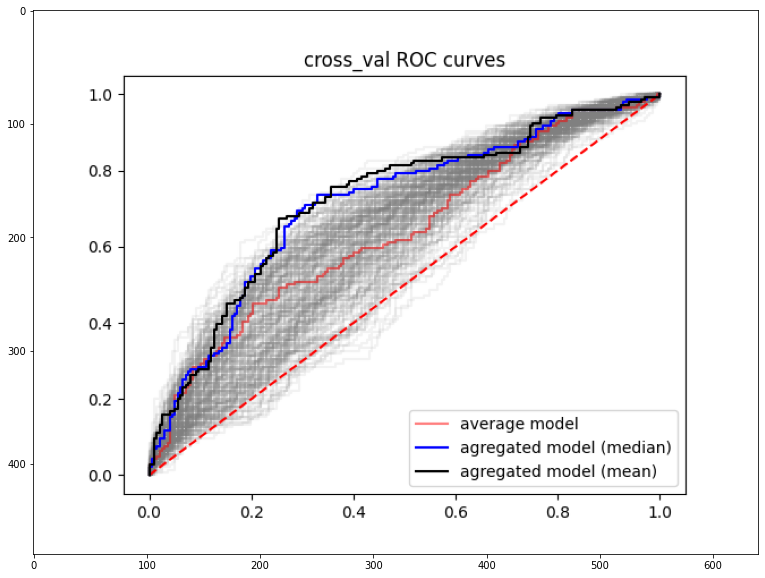

11-50-18
AUC [0.5071996615905245, 0.05657182074861448]


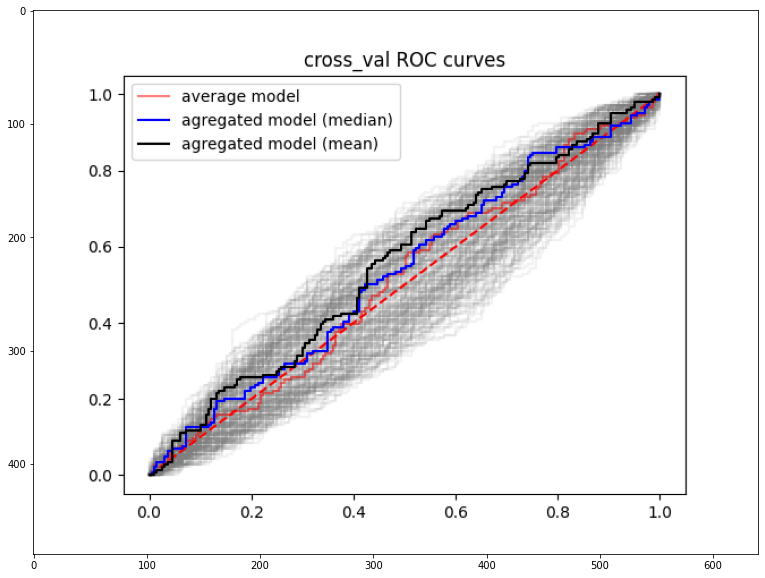

09-39-07
AUC [0.5236298646362099, 0.04399630494770008]


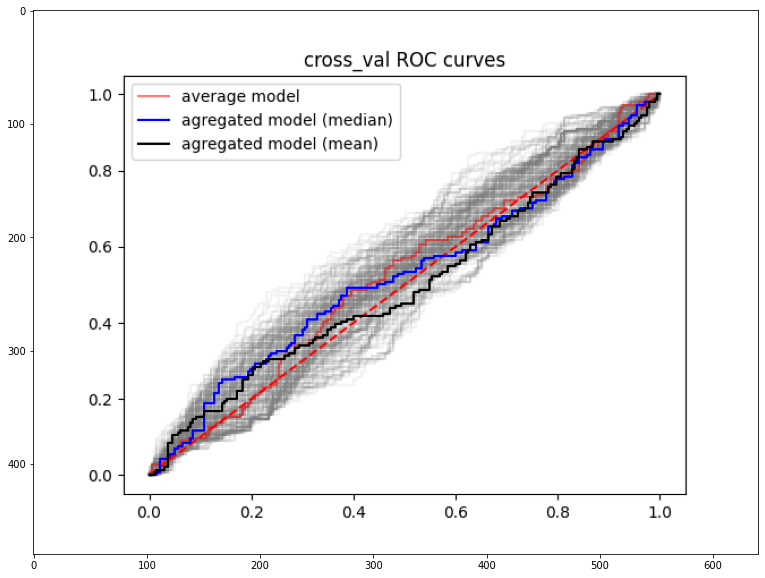

17-03-55
AUC [0.5886023688663282, 0.003672619852575254]


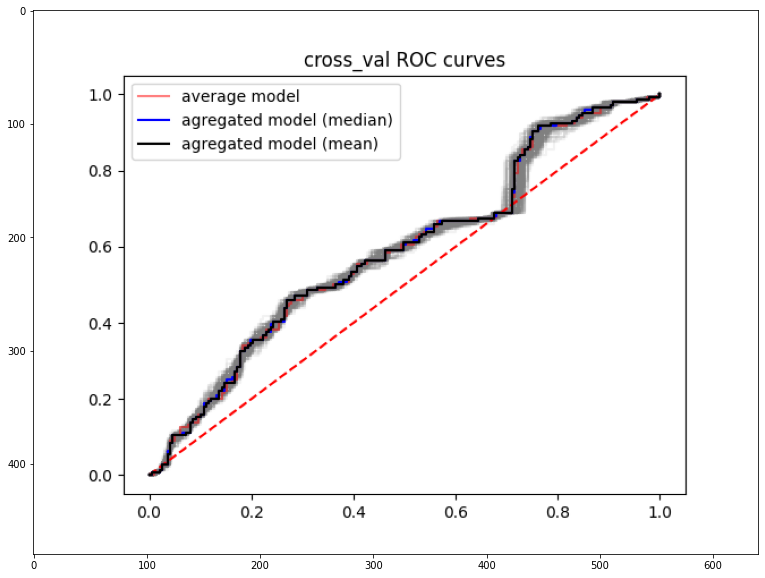

18-02-12
AUC [0.5146113931190073, 0.019472495716214087]


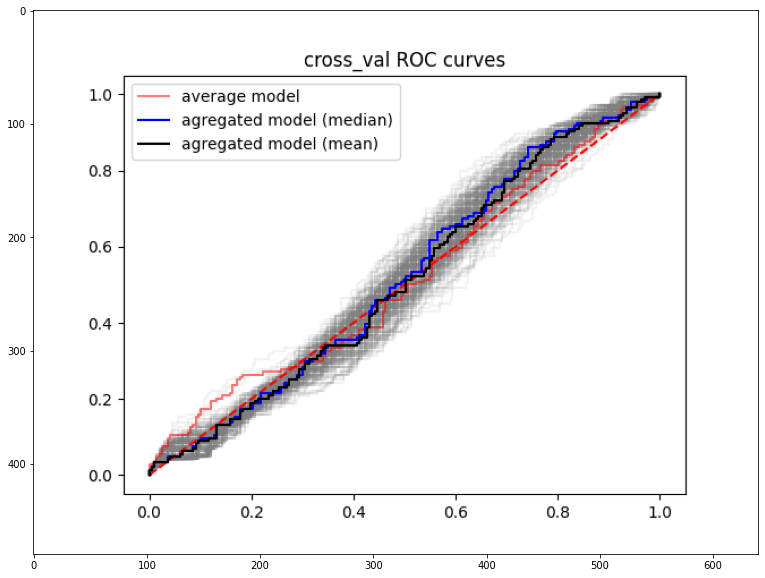

19-21-12
AUC [0.5951425549915398, 0.079696621433361]


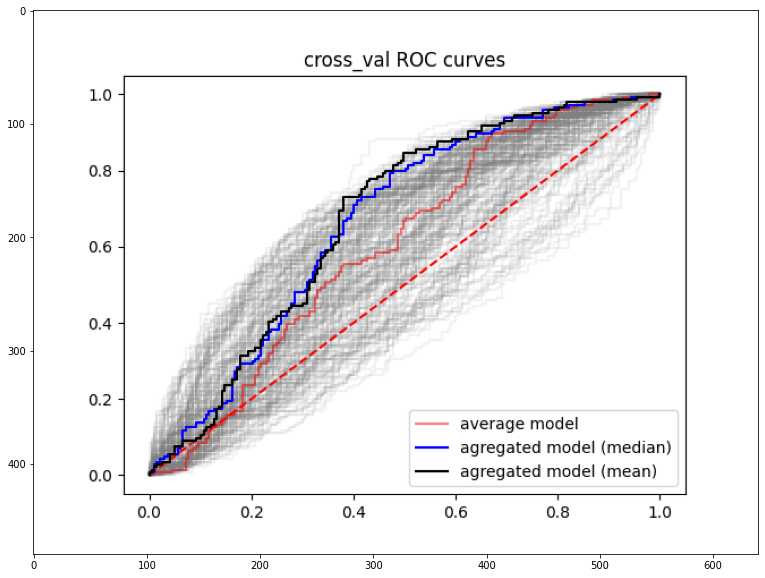

20-20-23
AUC [0.7218228990411731, 0.04826121242652944]


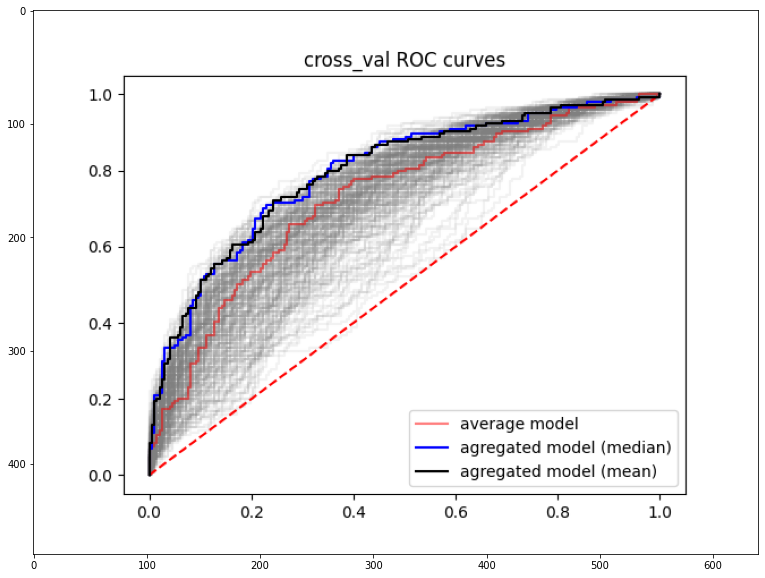

20-52-23
AUC [0.6685346869712353, 0.0014932910336374397]


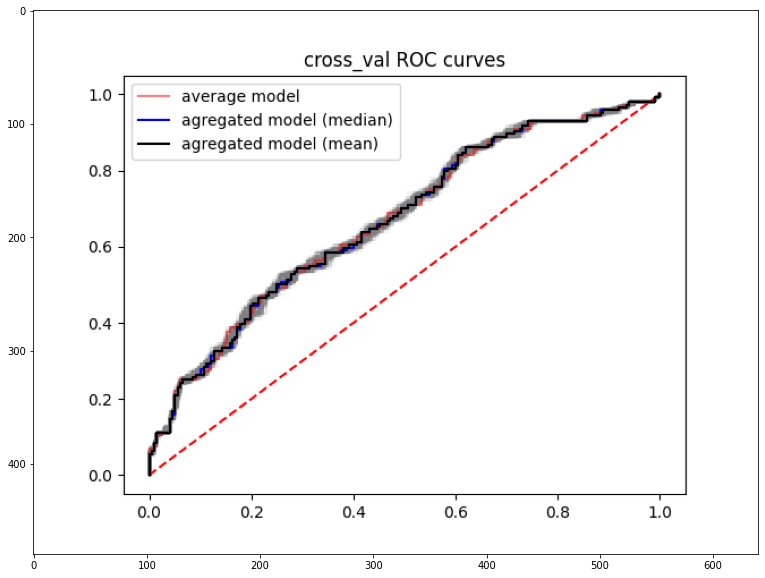

20-26-42
AUC [0.6493565989847715, 0.009484732086085836]


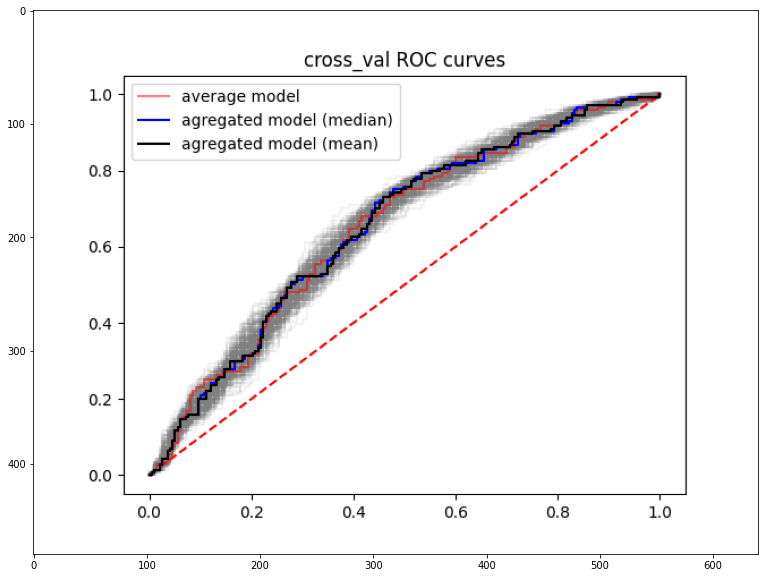

19-45-55
AUC [0.6798554709531865, 0.05011533484244626]


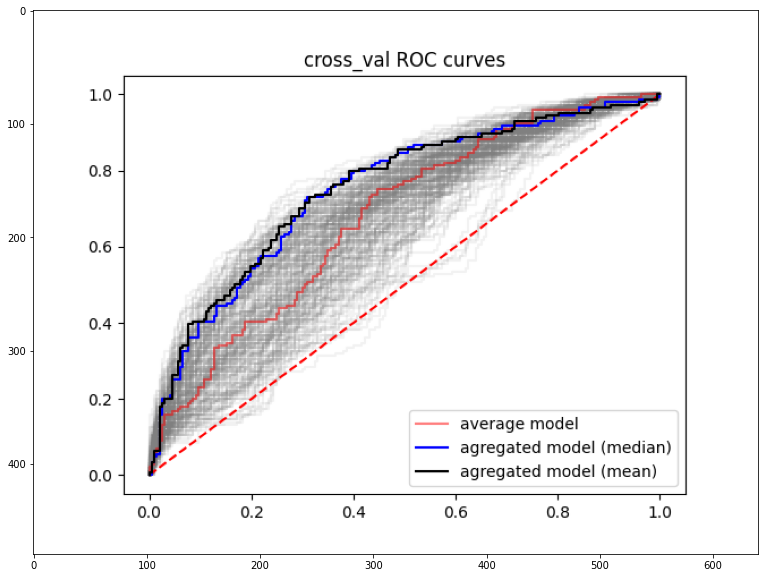

14-56-39
AUC [0.7426311336717428, 0.004457390838817733]


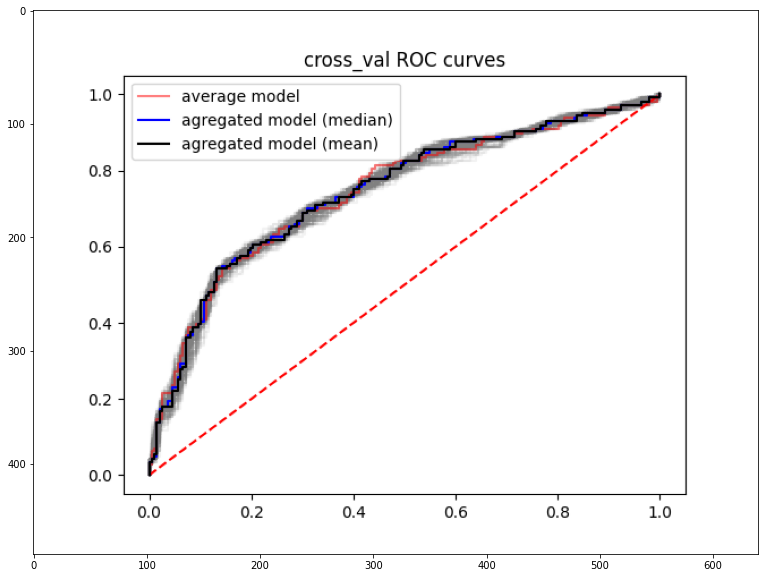

14-56-06
AUC [0.6641718838127467, 0.002534168919394373]


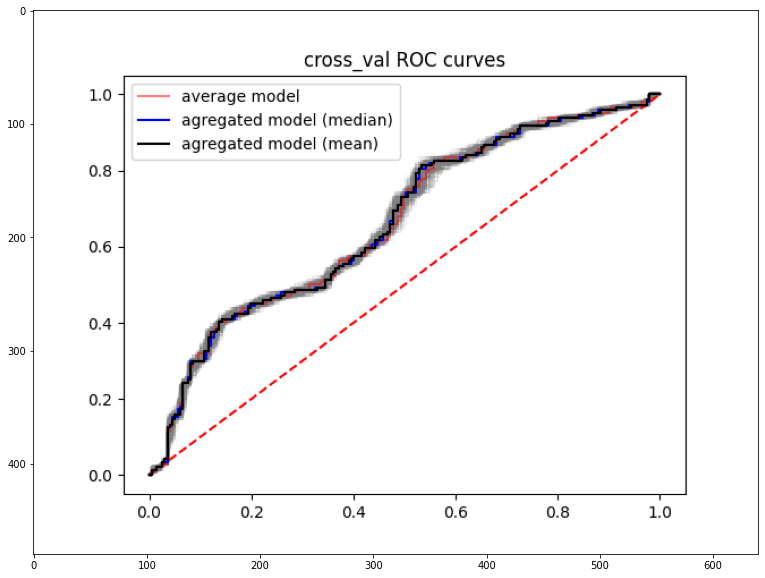

18-58-23
AUC [0.51398209249859, 0.052658610243139774]


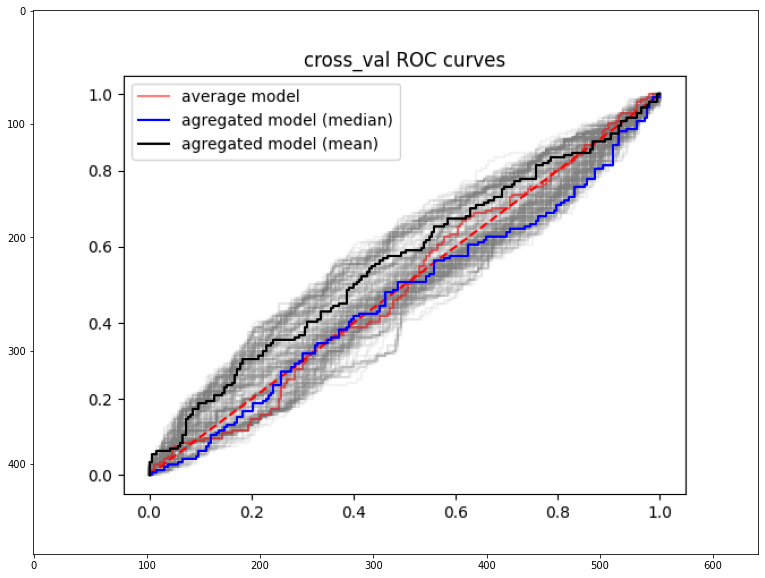

19-32-12
AUC [0.5401491821771011, 0.02464811502258309]


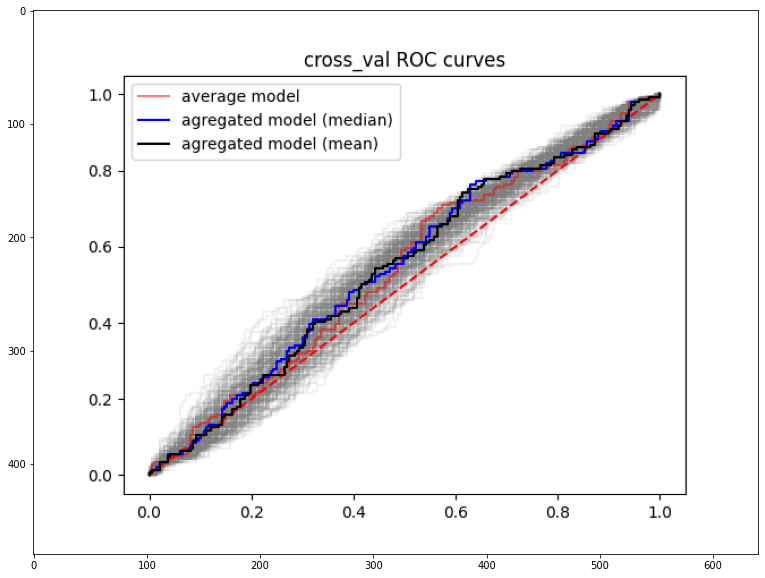

11-13-05
AUC [0.5621383248730963, 0.09775843422621118]


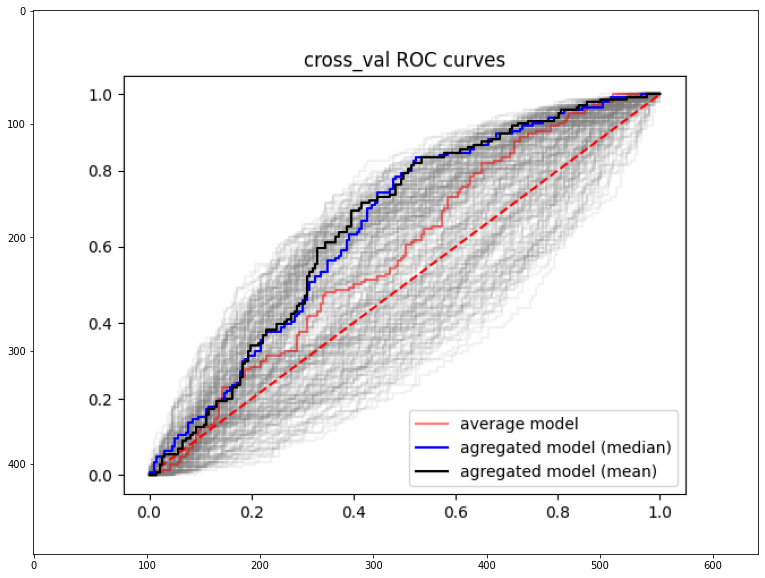

09-38-17
AUC [0.5009201917653694, 0.0409487393480931]


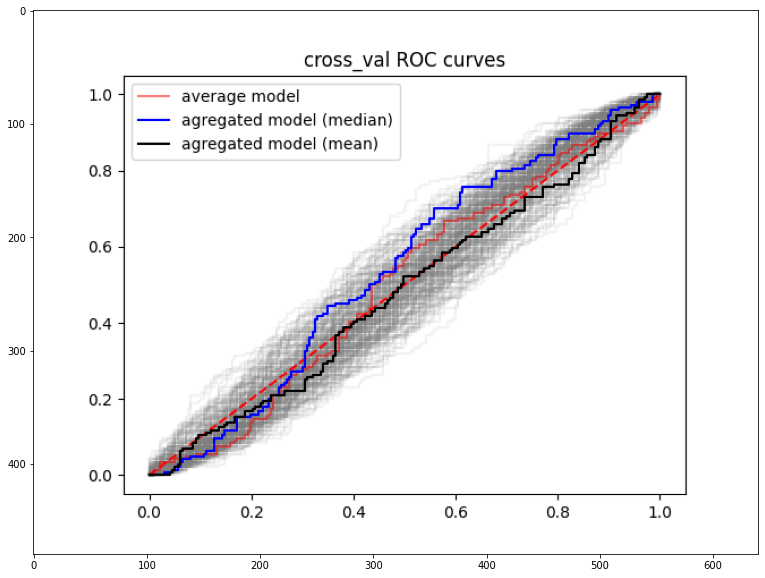

17-57-58
AUC [0.5792026226734348, 0.007102039688524289]


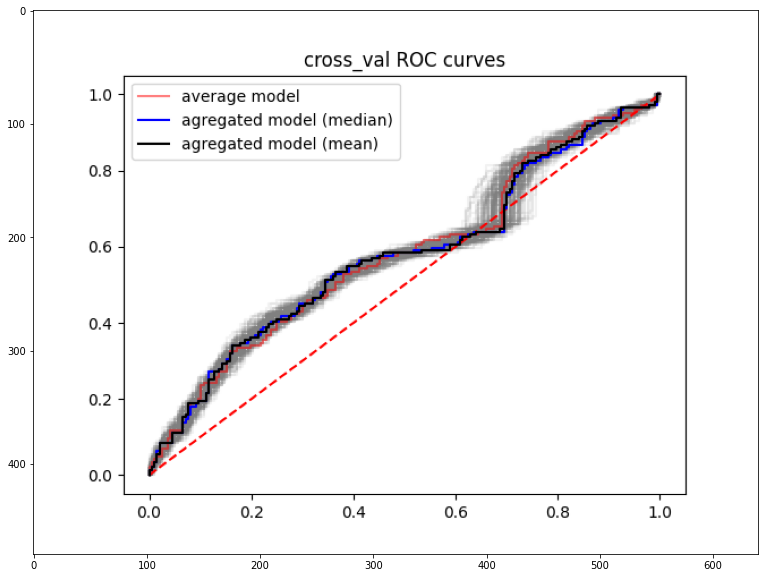

11-12-30
AUC [0.5207877890580938, 0.047745147991518175]


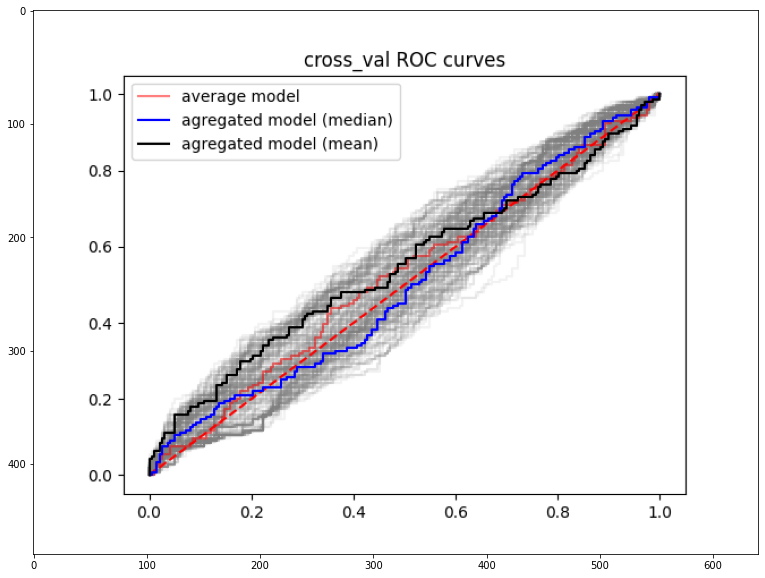

,path,auc,auc_std,accuracy,accuracy_std
0,19-47-08,0.637549,0.050771,0.569302,0.050761
1,11-50-18,0.507200,0.056572,0.518393,0.041281
2,09-39-07,0.523630,0.043996,0.510416,0.047795
3,17-03-55,0.588602,0.003673,0.607085,0.004779
4,18-02-12,0.514611,0.019472,0.564974,0.018250
5,19-21-12,0.595143,0.079697,0.563062,0.052327
6,20-20-23,0.721823,0.048261,0.631249,0.058619
7,20-52-23,0.668535,0.001493,0.622792,0.001763
8,20-26-42,0.649357,0.009485,0.608739,0.012312
9,19-45-55,0.679855,0.050115,0.594299,0.058476


In [5]:
excluded_conditions = []

results_df = show_results("/neurospin/dico/agaudin/Runs/04_pointnet/Output/2022-10-06",
excluded_conditions=excluded_conditions)

results_df

In [6]:
results_df.sort_values(ascending=False, by='auc')[['path', 'auc']]

,path,auc
10,14-56-39,0.742631
6,20-20-23,0.721823
9,19-45-55,0.679855
7,20-52-23,0.668535
11,14-56-06,0.664172
8,20-26-42,0.649357
0,19-47-08,0.637549
5,19-21-12,0.595143
3,17-03-55,0.588602
16,17-57-58,0.579203


In [7]:
# directories are supposed to have a certain structure and name patterns
def get_results_table(dir_path, model_types=['convnet', 'densenet2'], verbose=False):
    results = {k: {} for k in model_types}

    for model_type in os.listdir(dir_path):
        if model_type in model_types:
            if verbose:
                print(model_type)
            path = os.path.join(dir_path, model_type)
            for params in os.listdir(path):
                params_path = os.path.join(path, params)
                if os.path.isdir(params_path):
                    if verbose:
                        print(params)
                    
                    n_models = 0

                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = 0
                        results[model_type]['no_foldlabel_'+params] = 0
                    else:    
                        results[model_type][params] = 0
                    
                    for model in os.listdir(params_path):
                        model_path = os.path.join(params_path, model)
                        # start a model name by & to filter it out of the performance analysis
                        if os.path.isdir(model_path) and model[0] != '&':
                            if verbose:
                                print(model)

                            n_models += 1

                            if model_type == 'pca':
                                values = os.path.join(params_path, model, 'values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type]['foldlabel_'+params] += values['cross_val_auc'][0]
                                results[model_type]['no_foldlabel_'+params] += values['cross_val_auc'][0]
                            else:
                                values = os.path.join(params_path, model, 'cingulate_ACCpatterns_0_embeddings/values.json')
                                with open(values, 'r') as file:
                                    values = json.load(file)
                                results[model_type][params] += values['cross_val_auc'][0]
                    
                    if model_type == 'pca':
                        results[model_type]['foldlabel_'+params] = results[model_type]['foldlabel_'+params]/n_models
                        results[model_type]['no_foldlabel_'+params] = results[model_type]['no_foldlabel_'+params]/n_models
                    else:
                        results[model_type][params] = results[model_type][params]/n_models
    
    results_df = pd.DataFrame(results)
    results_df.sort_index(inplace=True)
    return results_df

In [8]:
dir_path = "/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders"
results_df = get_results_table(dir_path, model_types=['convnet', 'densenet2', 'pca'])

results_df.to_csv("/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/performance_comparison_5000.csv")

results_df

FileNotFoundError: [Errno 2] No such file or directory: '/neurospin/dico/agaudin/Runs/03_monkeys/Output/analysis_folders/densenet2/foldlabel_4/10-29-24/cingulate_ACCpatterns_0_embeddings/values.json'

## Use the database

In [30]:
bdd = import_bdd("/neurospin/dico/agaudin/Runs/new_bdd_models_0.csv", verbose=True)
bdd

path /neurospin/dico/agaudin/Runs/new_bdd_models_0.csv
13 have been removed for bad learning


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
34,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.760827,0.004171,0.703388,1.314837e-02,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.240257,1.669160,False,0.078811,cingulate_HCP_half_1,Run_03_aymeric
66,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.749497,0.005254,0.668212,9.068719e-03,convnet,16,0.05,100,False,...,30,30,0.1,0.1,0.086302,0.153539,False,-0.147380,cingulate_HCP_half_1,Run_03_aymeric
53,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.742650,0.001482,0.662259,8.020182e-03,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.374010,1.463949,False,0.199899,cingulate_HCP_half_1,Run_03_aymeric
45,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.740142,0.013671,0.694188,1.706071e-02,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.954553,2.959328,False,0.652514,cingulate_HCP_half_1,Run_03_aymeric
54,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.736406,0.003110,0.698071,6.666593e-03,convnet,16,0.05,100,True,...,4,4,0.1,0.1,1.251985,1.929024,False,0.594088,cingulate_HCP_half_1,Run_03_aymeric
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.492465,0.043720,0.507271,4.142626e-02,densenet,16,0.05,100,False,...,4,4,0.1,0.1,2.403121,2.404048,False,0.060130,cingulate_HCP_half_1,Run_03_aymeric
28,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.487215,0.045323,0.514894,4.708858e-02,densenet,16,0.05,100,False,...,4,4,0.1,0.1,3.181860,3.173622,False,0.149392,cingulate_HCP_half_1,Run_03_aymeric
1,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.476762,0.028876,0.516659,2.880058e-02,densenet,16,0.15,100,False,...,30,30,0.5,0.5,3.791713,3.817966,False,-0.021195,cingulate_HCP_half_1,Run_03_aymeric
123,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.426186,0.015647,0.576471,1.110223e-16,pointnet,16,0.15,100,False,...,4,4,0.1,0.1,4.179968,3.784941,False,-0.562040,cingulate_HCP_half_1,pointnet


In [57]:
exclude_bdd = pd.read_csv("/neurospin/dico/agaudin/Runs/new_bdd_models.csv", index_col=0)
sigmoids = exclude_bdd[exclude_bdd.model_path.str.contains('sigmoid')]
sigmoids

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,dataset_name,git_branch
81,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.605882,0.042920,0.590628,0.033440,convnet,16,0.05,100,True,...,30,30,0.1,0.1,0.214677,0.632679,sigmoid,-0.274541,cingulate_HCP_half_1,Run_03_aymeric
82,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.654027,0.044210,0.617419,0.034154,convnet,16,0.05,100,False,...,30,30,0.1,0.1,0.133134,0.230621,sigmoid,NaN,cingulate_HCP_half_1,Run_03_aymeric
83,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.656794,0.024040,0.619226,0.023931,densenet,16,0.05,100,True,...,30,30,0.1,0.1,1.431554,3.383259,sigmoid,NaN,cingulate_HCP_half_1,Run_03_aymeric
84,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.525296,0.007671,0.529525,0.007129,densenet,16,0.05,100,False,...,30,30,0.1,0.1,0.630446,0.753126,sigmoid,NaN,cingulate_HCP_half_1,Run_03_aymeric
85,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.676890,0.006477,0.658792,0.007721,pointnet,16,0.05,100,True,...,30,30,0.1,0.1,1.691467,2.001589,sigmoid,NaN,cingulate_HCP_half_1,pointnet
86,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.633446,0.009114,0.632540,0.010598,pointnet,16,0.05,100,False,...,30,30,0.1,0.1,1.246490,0.742785,sigmoid,NaN,cingulate_HCP_half_1,pointnet


In [13]:
columns_of_interest = ['backbone_name', 'batch_size', 'drop_rate', 'foldlabel', 'lr', 'num_outputs', 'num_representation_features',
'temperature', 'temperature_initial', 'dataset_name']

In [14]:
interesting_columns = ["model_path", 'auc', 'auc_std', 'backbone_name', 'batch_size', 'dataset_name', 'drop_rate', 'foldlabel',
                       'num_representation_features', 'temperature']
bdd[interesting_columns].iloc[:10,:]

KeyError: "['dataset_name', 'batch_size'] not in index"

### Performance histogram

In [39]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dimensions = [4, 30]

n_bb = len(backbones)
n_fold = len(foldlabels)
n_dims = len(dimensions)

colors = ['r', 'b', 'g']

pca4 = [0.537, 0.097]
pca10 = [0.548, 0.074]
pca30 = [0.587, 0.055]

bdd_05 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.05)]
clean_bdd = bdd_05
bdd_15 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.15)]

In [40]:
def performance_histogram(bdd, main, x, y, filters, colors=['r', 'b', 'g'], extended=True):
    n_x = len(x)
    n_y = len(y)
    
    plt.figure()
    bins = np.arange(0.45, 0.71, step=0.01)

    for i,element in enumerate(main):
        filtered_bdd = bdd[(bdd[filters[0]] == element) & ~(bdd.model_path.str.contains('unfinished'))]
        print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
        plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)
        plt.xlabel('auc')
    
    if main == dimensions:
        ax = plt.gca()
        y_min, y_max = ax.get_ylim()
        plt.vlines(pca4[0], ymin=y_min, ymax=y_max, colors='blue')
        plt.vlines(pca30[0], ymin=y_min, ymax=y_max, colors='red')

    
    if main == foldlabels:
        plt.legend(["no_foldlabel", "foldlabel"])
    elif main == dimensions:
        plt.legend(['pca (dim=4)', 'pca (dim=30)'] + main)
    plt.show()

    if extended:
        plt.figure(figsize=(n_y*6.4, n_x*4.8))

        for j in range(n_x):
            for k in range(n_y):
                pre_filtered_bdd = bdd[(bdd[filters[1]] == x[j]) & (bdd[filters[2]] == y[k])]
                print(x[j], y[k])
                plt.subplot(n_x, n_y, k + n_y*j + 1)
                for i,element in enumerate(main):
                    filtered_bdd = pre_filtered_bdd[(pre_filtered_bdd[filters[0]] == element) & ~(pre_filtered_bdd.model_path.str.contains('unfinished'))]
                    print(f"{element}, N = {filtered_bdd.shape[0]}, mean performance: {filtered_bdd.auc.mean()}")
                    plt.hist(filtered_bdd['auc'].values, bins, color=colors[i], alpha=0.6)
                    plt.xlabel('auc')
                    plt.title(str(x[j])+' '+ str(y[k]))
                print()
                plt.legend(main)
        plt.show()

convnet, N = 21, mean performance: 0.6968863145201173
densenet, N = 24, mean performance: 0.6079313083890548
pointnet, N = 29, mean performance: 0.6293555074788684


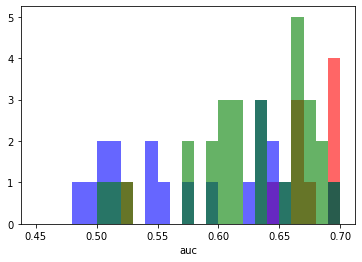

In [41]:
performance_histogram(clean_bdd, backbones, foldlabels, dimensions, filters=['backbone_name', 'foldlabel', 'num_representation_features'],
                      extended=False)

False, N = 34, mean performance: 0.6201338655820843
True, N = 40, mean performance: 0.6597930573339024


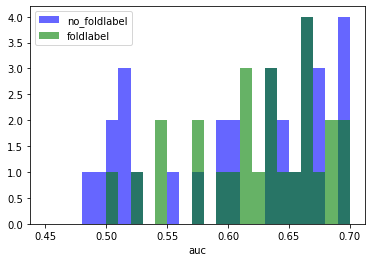

In [42]:
performance_histogram(clean_bdd, foldlabels, dimensions, backbones, filters=['foldlabel', 'num_representation_features', 'backbone_name'],
                      colors=['b', 'g'], extended=False)

4, N = 33, mean performance: 0.6191059377384601
30, N = 40, mean performance: 0.6597471617584294


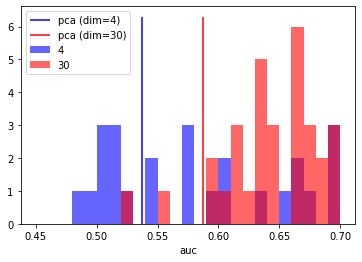

In [43]:
performance_histogram(clean_bdd, dimensions, foldlabels, backbones, filters=['num_representation_features', 'foldlabel', 'backbone_name'],
                      colors=['b', 'r'], extended=False)

### Results tables

In [44]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dimensions = [4, 30]

n_bb = len(backbones)
n_fold = len(foldlabels)
n_dims = len(dimensions)

colors = ['r', 'b', 'g']

pca4 = [0.537, 0.097]
pca10 = [0.548, 0.074]
pca30 = [0.587, 0.055]

bdd_05 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.05)]
clean_bdd = bdd_05
bdd_15 = bdd[(bdd.temperature == 0.1) & (bdd.drop_rate == 0.15)]

In [49]:
def significance_over_pca(backbone, foldlabel, dim, bdd=clean_bdd):
    filtered_df = clean_bdd[(clean_bdd.backbone_name == backbone) & (clean_bdd.foldlabel == foldlabel) & (clean_bdd.num_representation_features == dim)]
    aucs = filtered_df.auc

    if dim == 4:
        pca = pca4
    elif dim == 10:
        pca = pca10
    elif dim == 30:
        pca = pca30
    else:
        raise ValueError('Not a dimension the PCA is evaluated for')
    
    return ttest_1samp(aucs, pca[0])

In [46]:
backbones = ['convnet', 'densenet', 'pointnet']
dims = [4, 30]
foldlabels = [False, True]

idx = ['no foldlabel 4', 'foldlabel 4', 'no foldlabel 30', 'foldlabel 30']

df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
std_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
count_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones, dtype=int)
p_values_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)

for backbone in backbones:
    i = 0
    for dim in dims:
        for foldlabel in foldlabels:
            filtered_bdd = bdd_05[(bdd_05.backbone_name == backbone) & (bdd_05.foldlabel == foldlabel) & (bdd_05.num_representation_features == dim)]
            df[backbone][i] = filtered_bdd.auc.mean()
            std_df[backbone][i] = filtered_bdd.auc.std()
            count_df[backbone][i] =  filtered_bdd.count()[0]
            p_values_df[backbone][i] = significance_over_pca(backbone, foldlabel, dim, bdd=bdd_05)[1]
            i+=1


df

,convnet,densenet,pointnet
no foldlabel 4,0.693369,0.503456,0.566436
foldlabel 4,0.738893,0.565231,0.653466
no foldlabel 30,0.694047,0.615189,0.647987
foldlabel 30,0.661940,0.685664,0.647554


In [47]:
std_df

,convnet,densenet,pointnet
no foldlabel 4,0.024422,0.013514,0.049686
foldlabel 4,0.016590,0.056603,0.065810
no foldlabel 30,0.034445,0.038732,0.032650
foldlabel 30,0.083000,0.041692,0.031430


In [48]:
count_df

,convnet,densenet,pointnet
no foldlabel 4,6,5,7
foldlabel 4,5,5,5
no foldlabel 30,5,5,5
foldlabel 30,5,9,11


In [37]:
print(pca4[0], pca30[0])
p_values_df

0.539 0.595


,convnet,densenet,pointnet
no foldlabel 4,0.000020,0.004177,0.194329
foldlabel 4,0.000011,0.358625,0.017701
no foldlabel 30,0.003009,0.308563,0.022182
foldlabel 30,0.145661,0.000183,0.000246


#### Significantly over PCA

In [26]:
for backbone in backbones:
    i = 0
    for dim in dims:
        for foldlabel in foldlabels:
            _, p_value = significance_over_pca(backbone, foldlabel, dim)
            

Ttest_1sampResult(statistic=7.4853505647317204, pvalue=8.916594899289074e-07)

#### Dispersion table

In [50]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dims = [4, 30]

idx = ['no foldlabel 4', 'foldlabel 4', 'no foldlabel 30', 'foldlabel 30']

disp = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
disp_std = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)

for backbone in backbones:
    i = 0
    for dim in dims:
        for foldlabel in foldlabels:
            filtered_bdd = clean_bdd[(clean_bdd.backbone_name == backbone) & (clean_bdd.foldlabel == foldlabel) & (clean_bdd.num_representation_features == dim)]
            disp[backbone][i] = filtered_bdd.auc_std.mean()
            disp_std[backbone][i] = filtered_bdd.auc_std.std()
            i+=1

disp

,convnet,densenet,pointnet
no foldlabel 4,0.005374,0.054349,0.010358
foldlabel 4,0.004623,0.075918,0.002809
no foldlabel 30,0.005019,0.034892,0.009016
foldlabel 30,0.024701,0.046243,0.008504


In [51]:
disp_std

,convnet,densenet,pointnet
no foldlabel 4,0.003242,0.009415,0.005157
foldlabel 4,0.005238,0.013172,0.001687
no foldlabel 30,0.000205,0.002413,0.001298
foldlabel 30,0.030481,0.004386,0.002426


### Other parameters repartition

In [16]:
backbones = ['convnet', 'densenet', 'pointnet']
foldlabels = [False, True]
dims = [4, 30]

idx = ['no foldlabel 4', 'no foldlabel 30', 'foldlabel 4', 'foldlabel 30']

df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones)
count_df = pd.DataFrame(np.zeros((4,3)), index=idx, columns=backbones, dtype=int)


for backbone in backbones:
    i = 0
    for foldlabel in foldlabels:
        for dim in dims:
            filtered_bdd = bdd[(bdd.backbone_name == backbone) & (bdd.foldlabel == foldlabel) & (bdd.num_representation_features == dim)]
            filtered_bdd = filtered_bdd[(filtered_bdd.temperature == 0.1) & (filtered_bdd.drop_rate == 0.15)]
            df[backbone][i] = filtered_bdd.auc.mean()
            count_df[backbone][i] =  filtered_bdd.count()[0]
            i+=1

df

,convnet,densenet,pointnet
no foldlabel 4,0.525272,0.483569,0.486872
no foldlabel 30,0.641102,0.575910,0.590656
foldlabel 4,0.600475,0.583352,0.620886
foldlabel 30,0.609199,0.658608,0.635833


In [17]:
# 0.15
count_df

,convnet,densenet,pointnet
no foldlabel 4,5,4,1
no foldlabel 30,11,5,3
foldlabel 4,5,4,2
foldlabel 30,6,5,4


In [30]:
bdd[bdd.temperature != 0.1].groupby(['backbone_name', 'num_representation_features', 'foldlabel']).count()

,,,model_path,auc,auc_std,accuracy,accuracy_std,drop_rate,early_stopping_patience,lr,max_angle,max_epochs,num_outputs,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,git_branch
backbone_name,num_representation_features,foldlabel,,,,,,,,,,,,,,,,,,
densenet,30,False,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


### Correlations

In [34]:
def plot_correlation(x,y, xlabel='', ylabel='', title=''):

    x_regline = x.values.reshape((-1,1))
    y_regline = y.values.reshape((-1,1))
    regline = LinearRegression()
    regline.fit(x_regline, y_regline)

    r, p = pearsonr(x,y)

    plt.figure()
    plt.scatter(x,y)
    x_min = np.min(x)
    x_max = np.max(x)
    y_min = regline.predict([[x_min]])[0]
    y_max = regline.predict([[x_max]])[0]
    plt.plot([x_min, x_max], [y_min, y_max], color='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title+"r = {:.2f}, p = {:.2E}".format(r, p))

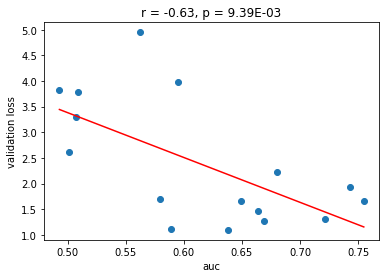

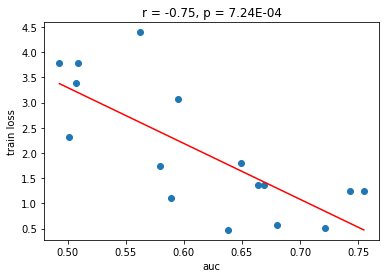

In [35]:
plot_correlation(bdd.auc, bdd.val_loss, xlabel='auc', ylabel='validation loss')
plt.show()
plot_correlation(bdd.auc, bdd.train_loss, xlabel='auc', ylabel='train loss')
plt.show()

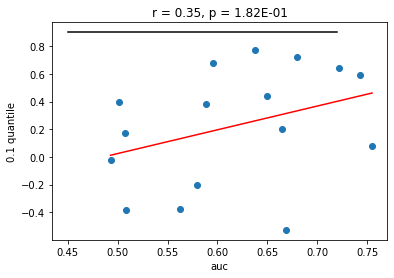

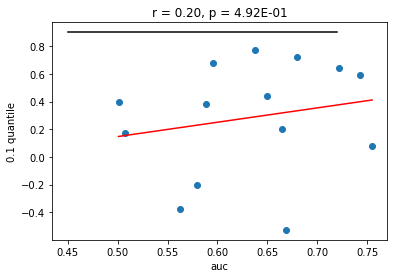

In [36]:
# 0.1 quantile and performance

filtered_bdd = bdd[~bdd['0.1_quantile'].isna()]


plot_correlation(filtered_bdd.auc, filtered_bdd['0.1_quantile'], xlabel='auc', ylabel='0.1 quantile')
plt.plot([0.45,0.72], [0.9, 0.9], color='black')
plt.show()

# same thing without the excluded ones
filtered_bdd = clean_bdd[~clean_bdd['0.1_quantile'].isna()]

plot_correlation(filtered_bdd.auc, filtered_bdd['0.1_quantile'], xlabel='auc', ylabel='0.1 quantile')
plt.plot([0.45,0.72], [0.9, 0.9], color='black')
plt.show()


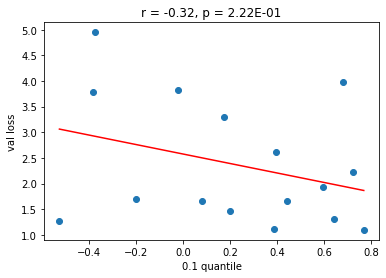

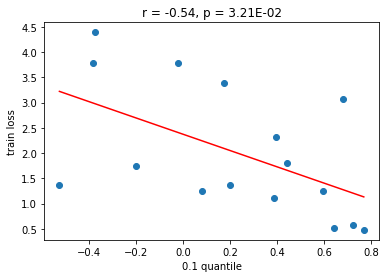

In [37]:
# 0.1 quantile and loss

filtered_bdd = bdd[~bdd['0.1_quantile'].isna()]

plot_correlation(filtered_bdd['0.1_quantile'], filtered_bdd.val_loss,  xlabel='0.1 quantile', ylabel='val loss')
plt.show()
plot_correlation(filtered_bdd['0.1_quantile'], filtered_bdd.train_loss,  xlabel='0.1 quantile', ylabel='train loss')
plt.show()

In [38]:
bdd.iloc[-10:,:]

,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,drop_rate,early_stopping_patience,foldlabel,lr,...,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,exclude,0.1_quantile,git_branch
21,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.649357,0.009485,0.608739,0.012312,convnet,0.05,100,False,0.0004,...,251,4,4,0.1,0.1,1.801281,1.665524,False,0.441741,Run_03_aymeric
19,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.637549,0.050771,0.569302,0.050761,densenet,0.05,100,True,0.0004,...,251,30,30,0.1,0.1,0.478128,1.096011,False,0.768694,Run_03_aymeric
16,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.595143,0.079697,0.563062,0.052327,densenet,0.05,100,True,0.0004,...,251,4,4,0.1,0.1,3.070811,3.984388,False,0.681085,Run_03_aymeric
12,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.588602,0.003673,0.607085,0.004779,convnet,0.05,100,False,0.0004,...,251,4,4,0.1,0.1,1.115199,1.120735,False,0.384894,Run_03_aymeric
13,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.579203,0.007102,0.609243,0.007729,convnet,0.05,100,False,0.0004,...,251,4,4,0.1,0.1,1.745262,1.695547,False,-0.202789,Run_03_aymeric
8,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.562138,0.097758,0.556375,0.069546,densenet,0.05,100,True,0.0004,...,251,4,4,0.1,0.1,4.393483,4.950019,False,-0.375490,Run_03_aymeric
0,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.508888,0.031385,0.517079,0.027080,densenet,0.15,100,False,0.0004,...,250,30,30,0.5,0.5,3.780218,3.786584,False,-0.384964,Run_03_aymeric
9,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.507200,0.056572,0.518393,0.041281,densenet,0.05,100,False,0.0004,...,251,4,4,0.1,0.1,3.381332,3.296130,False,0.173739,Run_03_aymeric
5,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.500920,0.040949,0.509314,0.039118,densenet,0.05,100,False,0.0004,...,251,4,4,0.1,0.1,2.321624,2.623530,False,0.395020,Run_03_aymeric
1,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.492988,0.028728,0.527543,0.024739,densenet,0.15,100,False,0.0004,...,250,30,30,0.5,0.5,3.791713,3.817966,False,-0.021195,Run_03_aymeric


In [39]:
pointnets = bdd[(bdd.backbone_name == 'pointnet')]
pointnets = pointnets[interesting_columns]
pointnets

KeyError: "['dataset_name', 'batch_size'] not in index"

In [40]:
# consistency analysis
# take models with the same parameters and compare the performance

params = ['backbone_name', 'batch_size', 'drop_rate', 'early_stopping_patience',
        'foldlabel', 'input_size', 'lr', 'max_angle', 'max_epochs',
        'num_outputs', 'num_representation_features', 'numpy_all',
        'temperature', 'temperature_initial', 'git_branch']

df = bdd[params]

bdd[df.duplicated(keep=False) & (bdd.backbone_name == 'pointnet')]


KeyError: "['batch_size', 'numpy_all', 'input_size'] not in index"

In [76]:
bad_models = bdd[bdd.auc <= 0.55]

print("proportion 4 parmi les mauvais modèles :", bad_models[bad_models.num_representation_features == 4].shape[0]/bad_models.shape[0])
print("proportion 4 parmi les modèles :", bdd[bdd.num_representation_features == 4].shape[0]/bdd.shape[0])

bad_models

proportion 4 parmi les mauvais modèles : 0.7931034482758621
proportion 4 parmi les modèles : 0.3853211009174312


,model_path,auc,auc_std,accuracy,accuracy_std,backbone_name,batch_size,drop_rate,early_stopping_patience,foldlabel,...,max_angle,max_epochs,num_outputs,num_representation_features,temperature,temperature_initial,train_loss,val_loss,dataset_name,git_branch
27,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.547569,0.057362,0.539683,0.044184,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.531240,4.867878,cingulate_HCP_half_1,Run_03_aymeric
34,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.540923,0.033724,0.539085,0.029719,densenet,16,0.15,100,False,...,10,250,30,30,0.1,0.1,0.491312,0.603156,cingulate_HCP_half_1,Run_03_aymeric
30,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.538566,0.027027,0.577713,0.000000,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,6.863671,6.433455,cingulate_HCP_half_1,Run_03_aymeric
76,/neurospin/dico/agaudin/Runs/04_pointnet/Outpu...,0.536983,0.005141,0.544880,0.003870,pointnet,16,0.05,100,True,...,6,250,4,4,0.5,0.5,4.673968,4.301939,cingulate_HCP_half_1,pointnet
8,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530707,0.044796,0.506229,0.049234,convnet,16,0.15,250,True,...,6,250,4,4,0.1,0.1,7.934582,6.433455,cingulate_HCP_half_1,Run_03_aymeric
57,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.530619,0.044917,0.518217,0.051808,convnet,16,0.60,100,False,...,10,250,30,30,0.1,0.1,6.863864,6.437438,cingulate_HCP_half_1,Run_03_aymeric
21,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.529559,0.046242,0.530170,0.036701,convnet,16,0.15,250,False,...,10,250,4,4,0.1,0.1,4.490583,2.484959,cingulate_HCP_half_1,Run_03_aymeric
29,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519898,0.052222,0.517889,0.044333,densenet,16,0.15,100,True,...,6,250,4,4,0.1,0.1,4.442244,5.053896,cingulate_HCP_half_1,Run_03_aymeric
18,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519531,0.036233,0.508657,0.047433,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,8.032898,6.433870,cingulate_HCP_half_1,Run_03_aymeric
16,/neurospin/dico/agaudin/Runs/03_monkeys/Output...,0.519293,0.042167,0.507683,0.046822,convnet,16,0.15,100,False,...,10,250,4,4,0.1,0.1,7.847290,6.433280,cingulate_HCP_half_1,Run_03_aymeric


### Compare full HCP and half HCP

In [41]:
# first batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 30)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 30) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

AttributeError: 'DataFrame' object has no attribute 'dataset_name'

In [42]:
# second batch

hcp_full = bdd[(bdd.dataset_name == 'cingulate_HCP_full') & (bdd.num_representation_features == 4)]
hcp_half = bdd[(bdd.dataset_name != 'cingulate_HCP_full') & (bdd.num_representation_features == 4) & (bdd.drop_rate == 0.05) & (bdd.foldlabel == True)]

print("Full:", hcp_full.auc.mean(), "Half:", hcp_half.auc.mean())

AttributeError: 'DataFrame' object has no attribute 'dataset_name'

Full HCP isn't worth it